# ♻️ Computer Vision in Recycling Management via Convolutional Neural Network (CNN)



## Getting Dataset from Kaggle
These steps requires Kaggle's Account Token.

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download techsash/waste-classification-data

 96% 412M/427M [00:02<00:00, 159MB/s]
100% 427M/427M [00:02<00:00, 163MB/s]


In [ ]:
! unzip waste-classification-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

## 🎛️ Setting up Preliminaries
Only packages been loaded up. No user-defined function defined.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

## 🛠️ Data Pre-Processing
Consist of Data Augmentation, Creating Directory for Validation data, and Image Normalization.

In [ ]:
train_path = "/content/DATASET/TRAIN"
test_path = "/content/DATASET/TEST"
validate_path = "/content/DATASET/VALIDATE"

### 🗃️ Data Augmentation
Augmentation of data is done by flipping images horizontally. This may help the CNN learns better.

In [ ]:
train_path_O = "/content/DATASET/TRAIN/O/"

for file in os.listdir(train_path_O+""):
    img = cv2.imread(train_path_O + file)
    horizontal_img = cv2.flip(img,1)
    filename = file.strip(".jpg")
    #saving now
    cv2.imwrite('/content/DATASET/TRAIN/O/' + filename +  "_flipped" + ".jpg", horizontal_img)

In [ ]:
train_path_R = "/content/DATASET/TRAIN/R/"

for file in os.listdir(train_path_R+""):
    img = cv2.imread(train_path_R + file)
    horizontal_img = cv2.flip(img,1)
    filename = file.strip(".jpg")
    #saving now
    cv2.imwrite('/content/DATASET/TRAIN/R/' + filename +  "_flipped" + ".jpg", horizontal_img)

### 📁 Creating new Directory for Validation data
Since we are using generators, we need to make new directory for Validation Generator. These images are approximately 10% taken from training image.

In [ ]:
from random import randrange

In [ ]:
newpath = r'/content/DATASET/VALIDATE/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
    os.makedirs(newpath + '/O/')
    os.makedirs(newpath + '/R/')

In [ ]:
for file in os.listdir(train_path_O+""):
    if randrange(10) == 3:
      img = cv2.imread(train_path_O + file)
      cv2.imwrite('/content/DATASET/VALIDATE/O/' + file, img)
      os.remove(train_path_O + file)

In [ ]:
for file in os.listdir(train_path_R+""):
    if randrange(10) == 3:
      img = cv2.imread(train_path_R + file)
      cv2.imwrite('/content/DATASET/VALIDATE/R/' + file, img)
      os.remove(train_path_R + file)

## 📊 Data Analysis and Visualization
Small insights from images of training dataset

In [ ]:
from collections import Counter

In [ ]:
x = [] 
y = [] 

for category in glob(train_path+'/*'):
    for file in glob(category+'/*'):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x.append(img_array) 
        y.append(category.split("/")[-1])
        
train_data = pd.DataFrame({'image': x,'type': y})

In [ ]:
train_data.shape

(40538, 2)

Pie Chart of Test Data Image Ratio Based on Types 'O' or 'R'

This may resulting in a bit of biasness since the model will be training considerably more images for Organic compared to Recyclable.

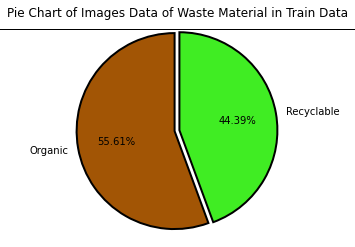

In [ ]:
plt.pie(train_data.type.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= ['#a25505','#40ed23'], radius=2, wedgeprops = { 'linewidth': 2, "edgecolor" :"k" })
plt.gca().axis("equal")
plt.title('Pie Chart of Images Data of Waste Material in Train Data', bbox={'facecolor':'1.0', 'pad':10})
plt.show()

Single Example of Train Data Set

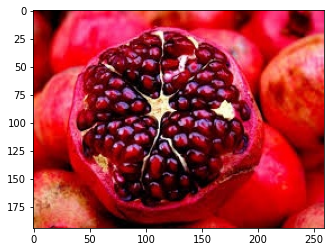

In [ ]:
plt.imshow(train_data.loc[0,'image'])

Set of Examples of Random Images in Train Data Set with Labels 

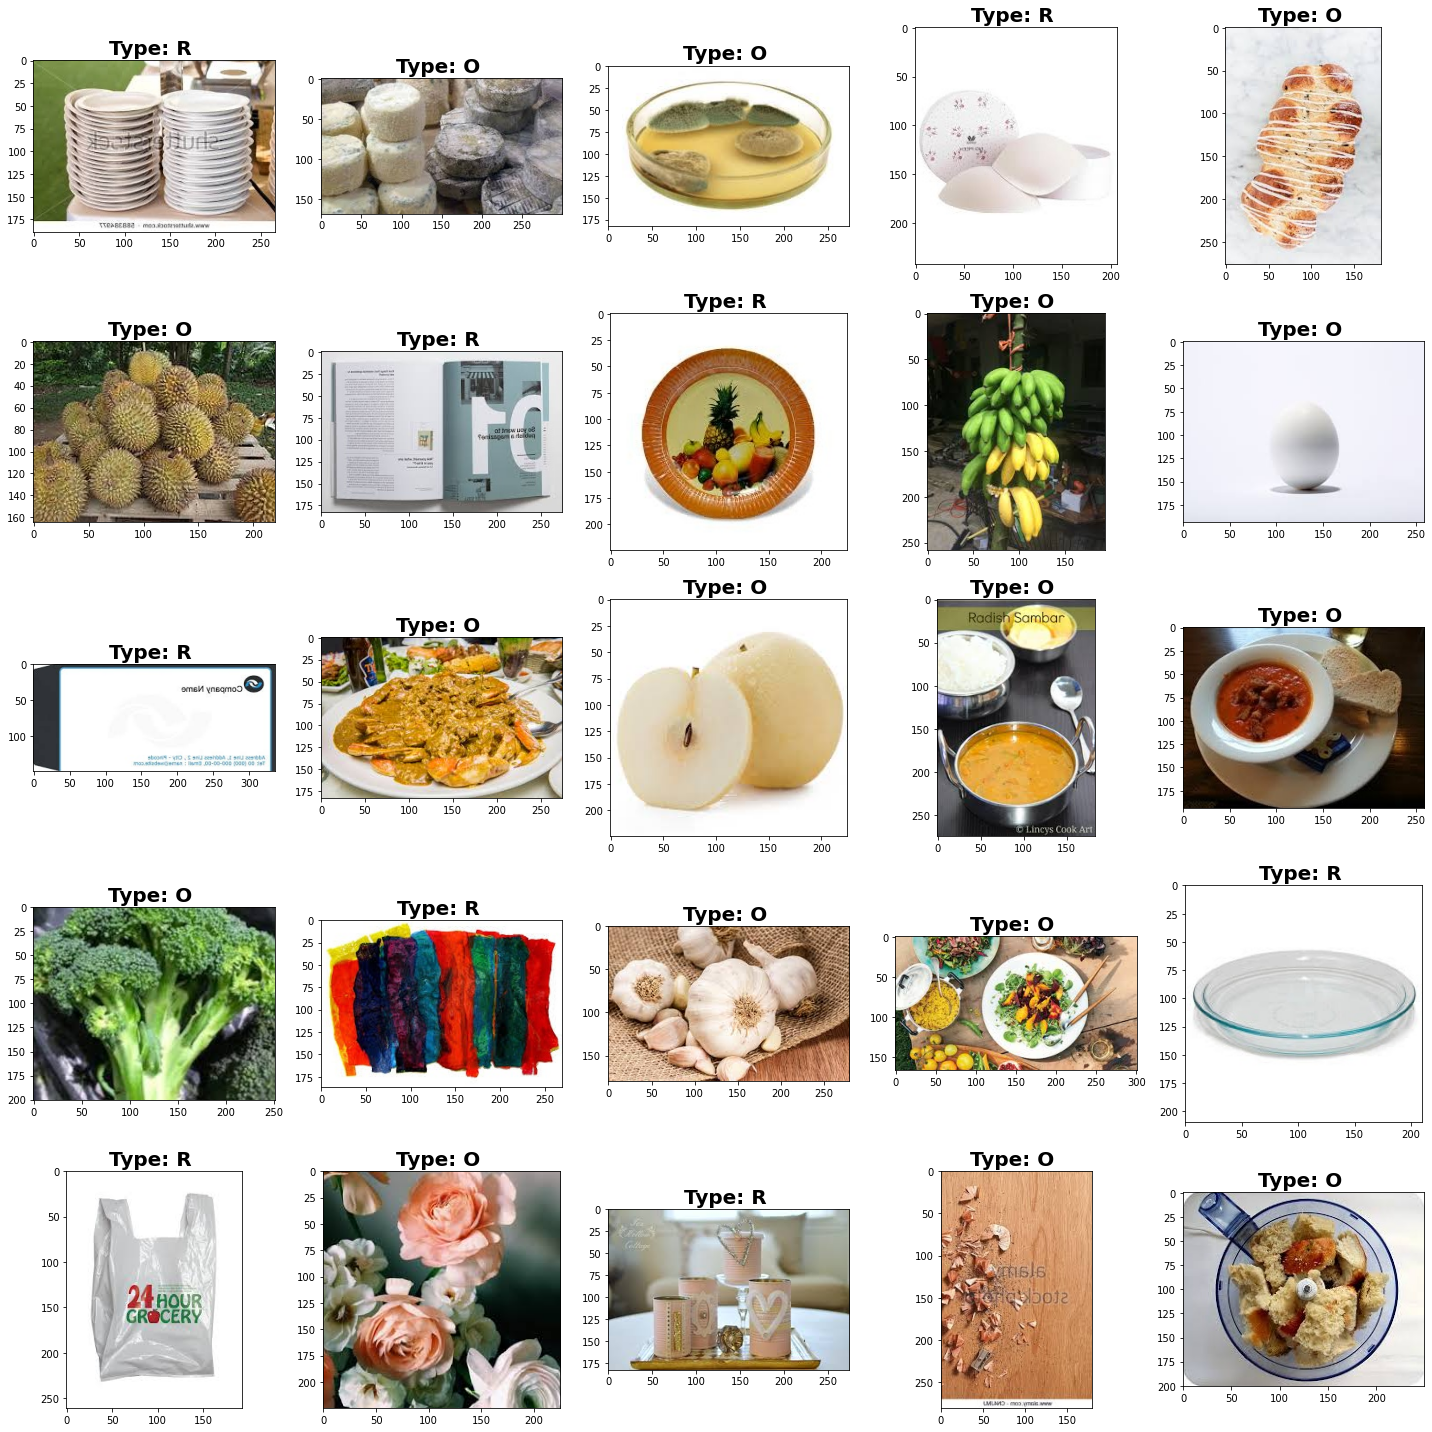

In [ ]:
plt.figure(figsize=(20,20))
for i in range(1,26):
    index = np.random.randint(train_data.shape[0])
    plt.subplot(5, 5, i)
    plt.imshow(np.squeeze(x[index]), cmap='cool')
    plt.title('Type: {0} '.format(train_data.type[index]),fontdict={'size':20,'weight':'bold'})
    plt.tight_layout()
plt.show()

## ⚙️ Model Training - Convolutional Neural Network

In [ ]:
import tensorflow as tf
import keras
from keras import callbacks
from tensorflow.keras import datasets, layers, models
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),

    layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),

    layers.Conv2D(filters=32, kernel_size=(4, 4), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    
    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

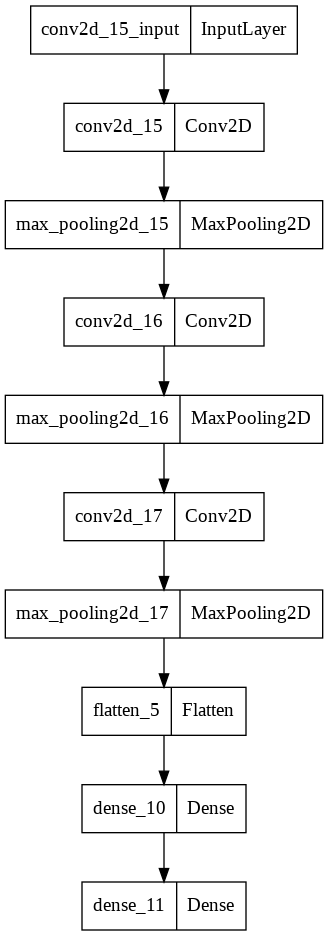

In [ ]:
plot_model(cnn)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)
validate_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size= (224,224), 
    batch_size = 64, 
    color_mode= "rgb", 
    class_mode= "categorical", 
    shuffle=True, 
    seed=123)

test_generator = test_datagen.flow_from_directory(
    test_path, 
    target_size= (224,224),
    batch_size = 64, 
    color_mode= "rgb", 
    class_mode= "categorical", 
    shuffle=False, 
    seed=None)

validate_generator = validate_datagen.flow_from_directory(
    validate_path, 
    target_size= (224,224),
    batch_size = 64, 
    color_mode= "rgb", 
    class_mode= "categorical", 
    shuffle=False, 
    seed=None)

Found 40538 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Found 4590 images belonging to 2 classes.


In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", patience = 3, restore_best_weights = True)

In [ ]:
training = cnn.fit_generator(generator = train_generator, epochs=25, validation_data = validate_generator, callbacks =[earlystopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
634/634 [==============================] - 104s 163ms/step - loss: 0.4052 - accuracy: 0.8249 - val_loss: 0.3438 - val_accuracy: 0.8582
Epoch 2/25
634/634 [==============================] - 101s 160ms/step - loss: 0.3303 - accuracy: 0.8618 - val_loss: 0.3323 - val_accuracy: 0.8621
Epoch 3/25
634/634 [==============================] - 101s 159ms/step - loss: 0.2925 - accuracy: 0.8802 - val_loss: 0.2959 - val_accuracy: 0.8800
Epoch 4/25
634/634 [==============================] - 101s 159ms/step - loss: 0.2572 - accuracy: 0.8951 - val_loss: 0.3038 - val_accuracy: 0.8778
Epoch 5/25
634/634 [==============================] - 101s 159ms/step - loss: 0.2180 - accuracy: 0.9098 - val_loss: 0.2932 - val_accuracy: 0.8902
Epoch 6/25
634/634 [==============================] - 100s 158ms/step - loss: 0.1682 - accuracy: 0.9343 - val_loss: 0.3149 - val_accuracy: 0.8854
Epoch 7/25
634/634 [==============================] - 101s 160ms/step - loss: 0.1244 - accuracy: 0.9521 - val_loss: 0.3446 -

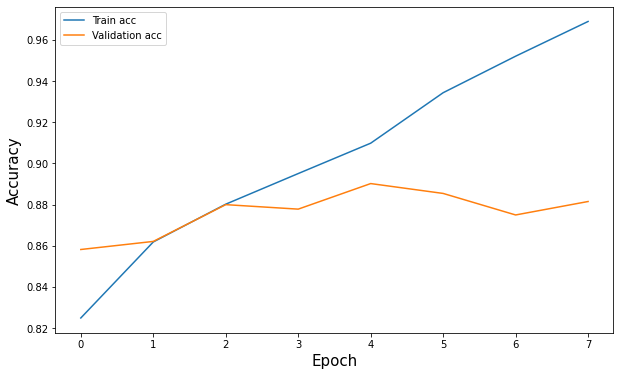

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(training.history["accuracy"], label = "Train acc")
plt.plot(training.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15) 
plt.show()

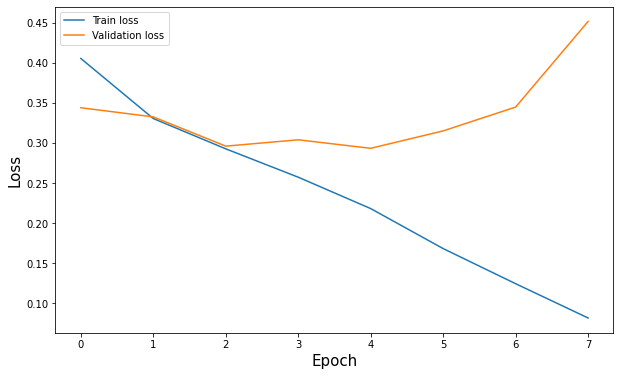

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(training.history['loss'], label = "Train loss")
plt.plot(training.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15) 
plt.show()

## 🧪 Model Testing
Predicting test images.

In [ ]:
predict = cnn.predict_generator(generator= test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


## ✅ Model Evaluation
Making sense of the Prediction results.

In [ ]:
loss, acc = cnn.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print("Evaluation of Test Generator Result:")
print("Accuracy : ", acc)
print("Loss : ", loss)

Evaluation of Test Generator Result:
Accuracy :  0.8965380191802979
Loss :  0.2943885624408722


### Classification Evaluation

In [ ]:
import seaborn as sns
import random
import pathlib
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
y_pred = np.argmax(predict, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Visual Example of Prediction vs Actual Label

In [ ]:
x_data = [] 

for category in glob(test_path+'/*'):
    for file in glob(category+'/*'):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 

In [ ]:
initial_count1 = 0
initial_count2 = 0
for path in pathlib.Path("/content/DATASET/TEST/O/").iterdir():
    if path.is_file():
        initial_count1 += 1

for path in pathlib.Path("/content/DATASET/TEST/R/").iterdir():
    if path.is_file():
        initial_count2 += 1

test_file_count = initial_count1 + initial_count2

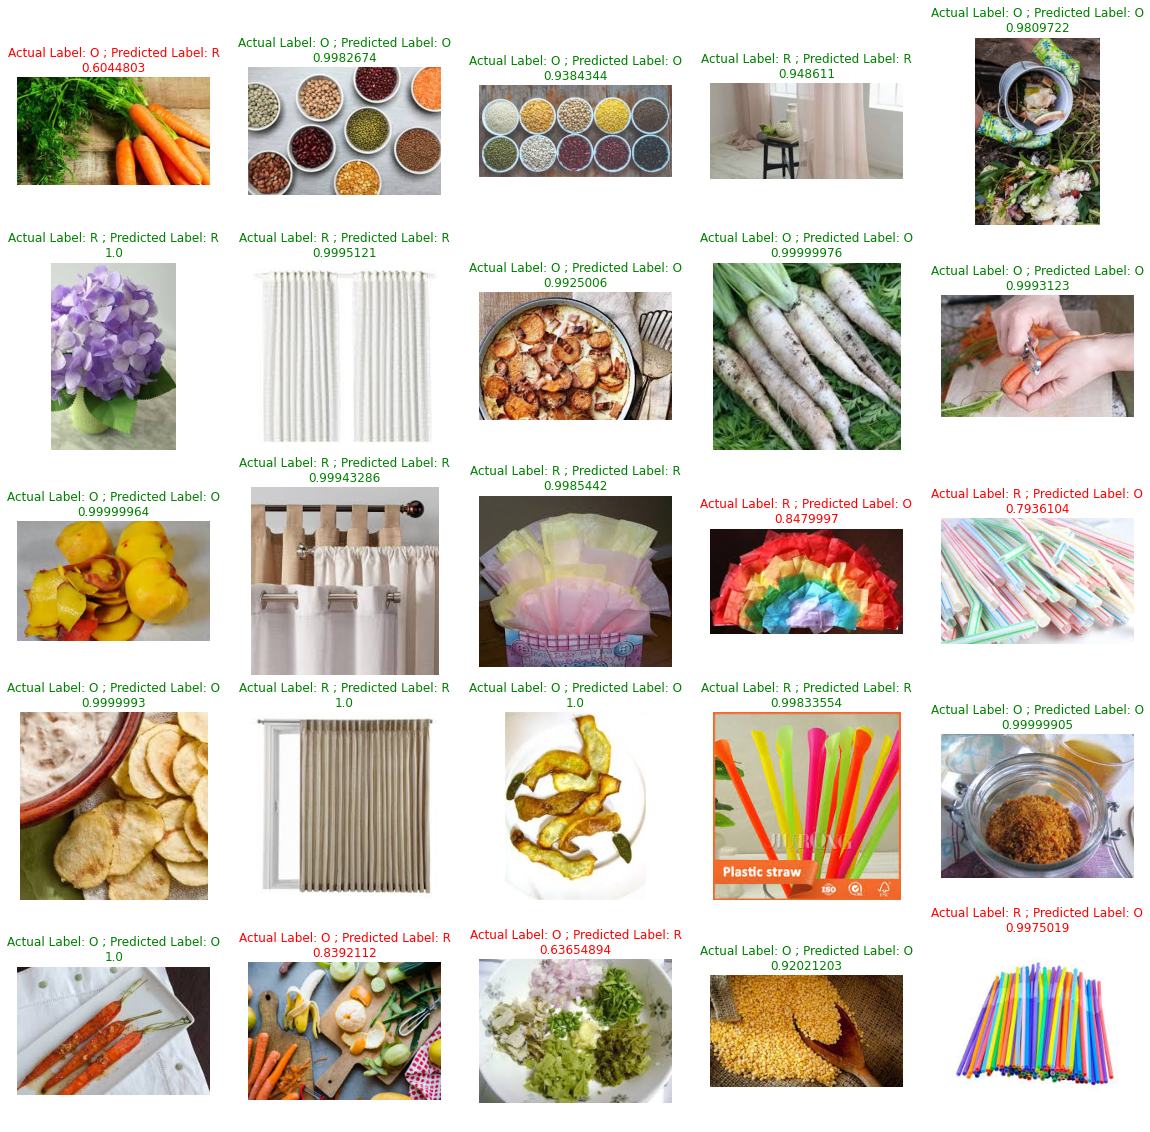

In [ ]:
plt.figure(figsize = (20,20))
for i in range(25):
    random_int_index = random.randint(0,test_file_count)
    plt.subplot(5,5,i+1)
    plt.imshow(x_data[random_int_index]/255.)
    if true_classes[random_int_index] == y_pred[random_int_index]:
        color = "g"
    else:
        color = "r"
    plt.title("Actual Label: " + class_labels[true_classes[random_int_index]] + " ; " + "Predicted Label: " +
              class_labels[y_pred[random_int_index]] + "\n" + 
              str(np.asarray(tf.reduce_max(predict, axis = 1))[random_int_index]), c=color)
    plt.axis(False);

confusion matrix

In [ ]:
cf_matrix = (confusion_matrix(true_classes, y_pred))

In [ ]:
cf_matrix = np.transpose(cf_matrix)

Text(33.0, 0.5, 'Predicted')

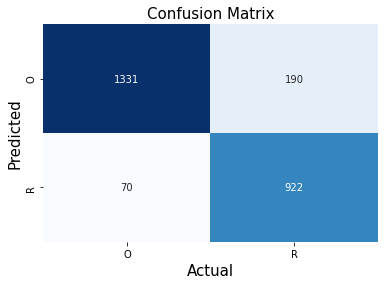

In [ ]:
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=['O','R'], yticklabels=['O','R'])

plt.title('Confusion Matrix', fontsize = 15)
plt.xlabel('Actual', fontsize = 15)
plt.ylabel('Predicted', fontsize = 15)

classification report

In [ ]:
report = classification_report(true_classes,  y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           O       0.88      0.95      0.91      1401
           R       0.93      0.83      0.88      1112

    accuracy                           0.90      2513
   macro avg       0.90      0.89      0.89      2513
weighted avg       0.90      0.90      0.90      2513

